In [34]:
# Imports
import numpy as np
import pandas as pd
import scipy.io as sio
import multiprocessing as mp
import os
import time
import statsmodels.api as sm
from scipy.stats import t as tstat
import matplotlib.pyplot as plt
import torch
from torch.nn import Sequential
from torch import nn
import torch.nn.functional as F
from torch import optim
from random import shuffle
from torchsummary import summary
from torch.autograd import Variable
import math
import tensorflow as tf
import statsmodels.api as sm
from scipy.stats import t as tstat

In [35]:
from statsmodels.tsa.stattools import adfuller

In [36]:
df_yield = pd.read_pickle('df_yield.pkl')
df_yield = df_yield.iloc[:-12,0:121]
df_yield = df_yield.set_index('Date')

In [37]:
# for i in range(1,13):
#     print(df_change.iloc[:,i*12-1])

In [38]:
y_excess = np.load('xrets.npy')
y_excess = np.squeeze(y_excess)
y_excess = np.transpose(y_excess)

df_excess = pd.DataFrame(y_excess, index = range(0,591),
             columns=['2y', '3y', '4y', '5y', '7y', '10y'])

<AxesSubplot:>

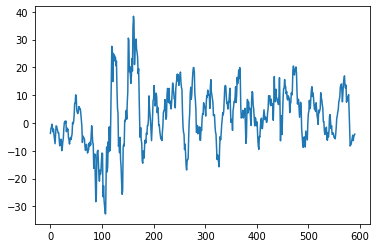

In [39]:
df_excess['10y'].plot()

### Testing for stationarity

In [40]:
adf_stat = []
adf_pvalue = []

for i in range(len(df_excess.columns)):
    adf_stat.append(adfuller(df_excess.iloc[:,i].values)[0])
    adf_pvalue.append(adfuller(df_excess.iloc[:,i].values)[1])
                    

In [41]:
df_adf = pd.concat([pd.DataFrame(adf_stat), pd.DataFrame(adf_pvalue)], axis = 1)

In [42]:
print(df_adf.to_latex())

\begin{tabular}{lrr}
\toprule
{} &         0 &         0 \\
\midrule
0 & -4.563359 &  0.000151 \\
1 & -4.306690 &  0.000433 \\
2 & -4.313529 &  0.000421 \\
3 & -4.330004 &  0.000394 \\
4 & -4.762179 &  0.000064 \\
5 & -4.980077 &  0.000024 \\
\bottomrule
\end{tabular}



In [43]:
# adf_stat_change = []
# adf_pvalue_change = []


# for i in range(1,13):
#     adf_stat_change.append(adfuller(df_change.iloc[:,i *12-1].values)[0])
#     adf_pvalue_change.append(adfuller(df_change.iloc[:,i *12-1].values)[1])

### Stationary yield dataset

In [44]:
yields = df_yield
# yields = df_yield.set_index("Date")
yields = yields
yields_reduced=yields
yield_changes = yields_reduced.diff(1)

In [45]:
hee = yield_changes.iloc[1:,]

In [46]:
yield_changes

,1m,2m,3m,4m,5m,6m,7m,8m,9m,10m,...,111m,112m,113m,114m,115m,116m,117m,118m,119m,120m
Date,,,,,,,,,,,,,,,,,,,,,
1971-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-01-11,-0.070235,-0.062978,-0.049014,-0.030356,-0.008872,0.013323,0.034268,0.052547,0.067253,0.077839,...,0.097757,0.095951,0.094174,0.092426,0.090709,0.089021,0.087359,0.085720,0.084096,0.082482
1971-01-12,-0.574607,-0.561954,-0.541666,-0.519226,-0.498776,-0.482282,-0.469521,-0.458935,-0.448623,-0.436888,...,0.012103,0.017779,0.023355,0.028829,0.034199,0.039461,0.044615,0.049658,0.054590,0.059408
1972-01-01,-0.308341,-0.317185,-0.323181,-0.322813,-0.314865,-0.300139,-0.280562,-0.258070,-0.234032,-0.209217,...,0.194824,0.194943,0.195024,0.195065,0.195063,0.195018,0.194928,0.194792,0.194609,0.194379
1972-01-02,0.011525,0.036018,0.051727,0.062217,0.070109,0.077506,0.085968,0.095818,0.105607,0.112078,...,-0.054288,-0.055065,-0.056013,-0.057145,-0.058472,-0.060005,-0.061754,-0.063726,-0.065927,-0.068362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-08,0.004085,0.005979,0.006396,0.005418,0.003525,0.001386,-0.000461,-0.001802,-0.002706,-0.003376,...,0.163952,0.165652,0.167329,0.168986,0.170607,0.172165,0.173633,0.175004,0.176315,0.177633
2020-01-09,0.000707,-0.003793,-0.007311,-0.009481,-0.010306,-0.010088,-0.009259,-0.008206,-0.007203,-0.006430,...,-0.029314,-0.029152,-0.028997,-0.028853,-0.028729,-0.028632,-0.028571,-0.028542,-0.028533,-0.028531
2020-01-10,-0.003697,0.003937,0.010525,0.015785,0.019685,0.022327,0.023873,0.024509,0.024443,0.023900,...,0.199026,0.199461,0.199916,0.200362,0.200758,0.201068,0.201274,0.201383,0.201423,0.201423


In [47]:
adfuller(hee['12m'].values)[1]

2.3981856630240243e-06

In [48]:
adf_stat_change = []
adf_pvalue_change = []


for i in [11, 23, 35, 47, 59, 71, 83, 95, 107, 119]:
    adf_stat_change.append(adfuller(df_change.iloc[:,i].values)[0])
    adf_pvalue_change.append(adfuller(df_change.iloc[:,i].values)[1])

NameError: name 'df_change' is not defined

In [ ]:
d = {}
for i in range(len(adf_stat_change)):
    d[i] = (adf_stat[i], adf_pvalue[i], adf_stat_change[i],adf_pvalue_change[i])

In [49]:
names_adf = ['Yield', 'p-value', 'Yield_change', 'p-value']

adf_df = pd.DataFrame(d)
adf_df = adf_df.transpose()

NameError: name 'd' is not defined

In [50]:
adf_df = adf_df.rename(columns={0:'Yield', 1:'p-value', 2:'Yield Change', 3:'p-value'})

NameError: name 'adf_df' is not defined

### Yield & Macro dataset

In [51]:
df_macro = pd.read_csv('Macroeconomic.csv')
df_macro =  df_macro.iloc[1:, :]
df_macro = df_macro.rename(columns={'sasdate': 'Date'})
df_macro = df_macro.iloc[:-1,:]

In [52]:
df_macro['Date'] = pd.to_datetime(df_macro['Date'])
df_macro['Date'] = df_macro['Date'].dt.strftime('%d-%m-%Y')

df_macro['Date'] = pd.to_datetime(df_macro['Date'])
mask = (df_macro['Date'] > '01-07-1971') & (df_macro['Date'] < '01-01-2021')

df_macro = df_macro.loc[mask]
df_macro = df_macro.iloc[2:,]

In [53]:
df_yield_macro = pd.merge(df_yield, df_macro, how = 'inner', on = 'Date')

### Stationary Yield & Macro dataset

In [54]:
df_change_macro = df_macro.iloc[1:,]

In [55]:
date = df_macro.iloc[:,0]
date = date.astype(str)
date = date.reset_index()
date = date.iloc[:,1:]

In [56]:
df_change = df_change.reset_index()
df_change = df_change.iloc[:,1:]
df_change = pd.merge(df_change, date, left_index = True, right_index = True)
df_change['Date'] = pd.to_datetime(df_change['Date'])

NameError: name 'df_change' is not defined

In [57]:
df_change_macro = pd.merge(df_change, df_change_macro, 'inner', on = 'Date')

NameError: name 'df_change' is not defined

### Smoothing datasets

$$s_t = \alpha x_t + (1-\alpha) * (s_{t-1} + b_{t-1})$$


$$b_{t} = \gamma * (s_{t} - s_{t-1} + (1- \gamma) * s_{t-1}) $$

$$ P_{t+m} = P_{t} + m*b_{t}$$

In [58]:
# Smoothin factor alpha
alpha = 0.5 # Check what to do with this later
gamma = 0.5


In [59]:
df_yield.iloc[:,]

,1m,2m,3m,4m,5m,6m,7m,8m,9m,10m,...,111m,112m,113m,114m,115m,116m,117m,118m,119m,120m
Date,,,,,,,,,,,,,,,,,,,,,
1971-01-10,4.112952,4.196824,4.269595,4.328237,4.372741,4.405902,4.432086,4.455566,4.479461,4.505534,...,5.739439,5.738954,5.738599,5.738385,5.738322,5.738422,5.738694,5.739152,5.739806,5.740668
1971-01-11,4.042717,4.133847,4.220581,4.297881,4.363869,4.419226,4.466354,4.508113,4.546714,4.583373,...,5.837195,5.834905,5.832773,5.830811,5.829031,5.827442,5.826054,5.824872,5.823902,5.823150
1971-01-12,3.468110,3.571893,3.678915,3.778655,3.865093,3.936943,3.996833,4.049177,4.098091,4.146485,...,5.849298,5.852683,5.856128,5.859640,5.863230,5.866904,5.870668,5.874530,5.878492,5.882558
1972-01-01,3.159769,3.254708,3.355734,3.455842,3.550228,3.636804,3.716271,3.791107,3.864059,3.937268,...,6.044123,6.047627,6.051152,6.054705,6.058293,6.061922,6.065596,6.069321,6.073101,6.076937
1972-01-02,3.171293,3.290726,3.407460,3.518059,3.620338,3.714310,3.802239,3.886925,3.969666,4.049347,...,5.989834,5.992562,5.995139,5.997560,5.999821,6.001916,6.003842,6.005595,6.007173,6.008575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-08,0.085829,0.093166,0.099664,0.105242,0.110026,0.114252,0.118142,0.121824,0.125334,0.128653,...,0.661140,0.666029,0.671024,0.676124,0.681321,0.686595,0.691912,0.697230,0.702510,0.707729
2020-01-09,0.086536,0.089373,0.092353,0.095761,0.099720,0.104164,0.108883,0.113618,0.118130,0.122223,...,0.631826,0.636877,0.642027,0.647271,0.652593,0.657963,0.663341,0.668688,0.673976,0.679197
2020-01-10,0.082839,0.093310,0.102878,0.111546,0.119405,0.126491,0.132756,0.138127,0.142573,0.146123,...,0.830852,0.836338,0.841942,0.847632,0.853351,0.859031,0.864615,0.870071,0.875400,0.880620


#### Smoothing yield

In [80]:
df_ES = df_yield.iloc[:,0:]
df_ES = df_ES.apply(lambda x: x.shift(1) * alpha + (1-alpha) * x)
df_ES = df_ES.reset_index()
df_ES = df_ES.iloc[:,1:]
# df_ES = pd.merge(df_ES, date,left_index = True, right_index = True)



In [82]:
import pickle

In [83]:
with open('df_smooth_yield.pkl', 'wb') as fp:
    pickle.dump(df_ES, fp)

In [71]:
with open('df_smooth_yield.pkl', 'rb') as fp:
    data = pickle.load(fp)

In [72]:
data

,2m,3m,4m,5m,6m,7m,8m,9m,10m,11m,...,112m,113m,114m,115m,116m,117m,118m,119m,120m,Date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1971-01-10
1,4.165336,4.245088,4.313059,4.368305,4.412564,4.449220,4.481839,4.513088,4.544454,4.576457,...,5.786929,5.785686,5.784598,5.783677,5.782932,5.782374,5.782012,5.781854,5.781909,1971-01-11
2,3.852870,3.949748,4.038268,4.114481,4.178084,4.231594,4.278645,4.322403,4.364929,4.407313,...,5.843794,5.844450,5.845226,5.846130,5.847173,5.848361,5.849701,5.851197,5.852854,1971-01-12
3,3.413301,3.517324,3.617249,3.707661,3.786874,3.856552,3.920142,3.981075,4.041877,4.104135,...,5.950155,5.953640,5.957173,5.960761,5.964413,5.968132,5.971926,5.975796,5.979747,1972-01-01
4,3.272717,3.381597,3.486951,3.585283,3.675557,3.759255,3.839016,3.916862,3.993307,4.067485,...,6.020094,6.023145,6.026132,6.029057,6.031919,6.034719,6.037458,6.040137,6.042756,1972-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,0.090177,0.096466,0.102533,0.108264,0.113559,0.118372,0.122725,0.126686,0.130341,0.133759,...,0.583203,0.587359,0.591631,0.596018,0.600513,0.605096,0.609728,0.614352,0.618912,2020-01-08
587,0.091269,0.096008,0.100501,0.104873,0.109208,0.113513,0.117721,0.121732,0.125438,0.128734,...,0.651453,0.656525,0.661697,0.666957,0.672279,0.677627,0.682959,0.688243,0.693463,2020-01-09
588,0.091341,0.097615,0.103653,0.109562,0.115327,0.120819,0.125872,0.130352,0.134173,0.137295,...,0.736607,0.741985,0.747452,0.752972,0.758497,0.763978,0.769379,0.774688,0.779909,2020-01-10
589,0.091480,0.098703,0.105254,0.111177,0.116450,0.121045,0.124986,0.128359,0.131283,0.133884,...,0.815384,0.820968,0.826630,0.832304,0.837920,0.843426,0.848800,0.854049,0.859190,2020-01-11


#### Smoothing change

In [21]:
df_smooth_change = df_change.iloc[:,:-1].apply(lambda x: x.shift(1) * alpha + (1-alpha) * x)
df_smooth_change = pd.merge(df_smooth_change, date,left_index = True, right_index = True)
# df_smooth_change

#### Smoothing Change & Macro

In [22]:
df_change_macro = df_change_macro.drop(labels = 'Date', axis = 1)
df_change_macro = df_change_macro.apply(lambda x: x.shift(1) * alpha + (1-alpha) * x)
df_change_macro = pd.merge(df_change_macro, date, left_index = True, right_index = True)

#### Smoothing Yield & Macro

In [23]:
df_yield_macro = df_yield_macro.iloc[:,1:].apply(lambda x: x.shift(1) * alpha + (1-alpha) * x)
df_yield_macro = pd.merge(df_yield_macro, date, left_index = True, right_index = True)

In [30]:
import pickle

In [200]:
with open('df_change', 'wb') as fp:
    pickle.dump(df_change, fp)
    
with open('df_smooth_change', 'wb') as fp:
    pickle.dump(df_smooth_change, fp)

with open('df_smooth_yield', 'wb') as fp:
    pickle.dump(df_smooth_yield, fp)

In [203]:
len(df_change.columns)

121

In [ ]:
df_change = df_yield.iloc[:,1:].diff(12)
df_change = df_change.iloc[12:,]

In [ ]:
with open('df_change', 'wb') as fp:
    pickle.dump(df_change, fp)

In [369]:
yields = df_yield
yields = df_yield.set_index("Date")
yields = yields.iloc[:,[11, 23, 35, 47, 59, 71, 83, 95, 107, 119]]
yields_reduced=yields
yield_changes = yields_reduced.diff(12)

In [459]:
with open('yield_changes', 'wb') as fp:
    pickle.dump(yield_changes, fp)

In [455]:
yield_changes

,12m,24m,36m,48m,60m,72m,84m,96m,108m,120m
Date,,,,,,,,,,
1971-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-01-11,0.086881,0.093600,0.096757,0.046463,0.039886,0.106105,0.134373,0.124964,0.103312,0.082482
1971-01-12,-0.404970,-0.250023,-0.237899,-0.254423,-0.266761,-0.245067,-0.167076,-0.082767,-0.005491,0.059408
1972-01-01,-0.157567,0.020787,0.201388,0.291283,0.283721,0.218773,0.190977,0.190419,0.194263,0.194379
1972-01-02,0.096911,-0.051670,-0.055982,-0.060082,-0.063620,-0.070804,-0.064062,-0.055600,-0.052860,-0.068362
...,...,...,...,...,...,...,...,...,...,...
2020-01-08,-0.004917,0.014854,0.033874,0.039507,0.051740,0.079775,0.105883,0.137857,0.158631,0.177633
2020-01-09,-0.005987,-0.005575,0.005286,0.000301,0.006705,-0.015398,-0.018747,-0.027405,-0.029721,-0.028531
2020-01-10,0.022367,0.032372,0.044649,0.081633,0.112473,0.152928,0.173194,0.191027,0.197766,0.201423


#### PC's look exactly like Hoogteijling et al.

In [371]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [372]:
pcr = PCA(n_components = 3)

In [373]:
yield_pca =  pcr.fit_transform(yields)

In [374]:
yield_change_pca = pcr.fit_transform(yield_changes.iloc[12:,])

<AxesSubplot:>

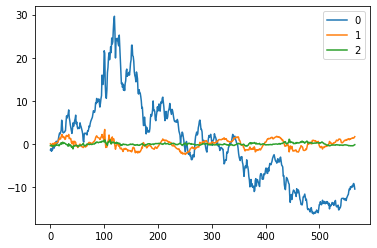

In [375]:
pd.DataFrame(yield_pca).plot()

<AxesSubplot:>

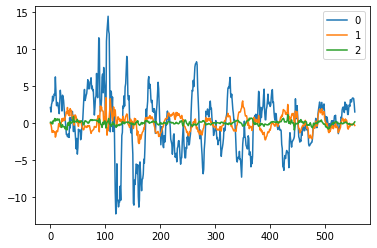

In [376]:
pd.DataFrame(yield_change_pca).plot()